In [4]:
import requests

import pandas as pd
import plotly.express as px

from datetime import date

In [46]:
key = 'f25b76598ebf3acf7c83ef22c62a541514f6d0ed3ac920f2c50a54b05bd66f31'
res = requests.get("https://api.openaq.org/v2/locations/2178", headers={"X-API-Key": key})

print(res)

<Response [200]>


In [70]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import time

def generate_date_ranges(start_date, end_date):
    """Generate monthly date ranges between start and end dates"""
    current_date = start_date
    while current_date < end_date:
        # Calculate end of current month
        next_month = current_date.replace(day=28) + timedelta(days=4)
        month_end = next_month - timedelta(days=next_month.day)
        
        # If month_end is after end_date, use end_date instead
        if month_end > end_date:
            month_end = end_date
            
        yield current_date, month_end
        current_date = month_end + timedelta(days=1)

def query_weather_data(location, start_date="2020-01-01", end_date="2024-09-30"):
    # Convert string dates to datetime objects
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    all_data = []
    
    # Generate monthly date ranges
    for period_start, period_end in generate_date_ranges(start_dt, end_dt):
        # Format dates for URL
        date_from = period_start.strftime("%Y-%m-%dT00:00:00Z")
        date_to = period_end.strftime("%Y-%m-%dT23:59:59Z")
        
        # Construct URL with date range
        url = (
            "https://api.openaq.org/v2/measurements"
            f"?date_from={date_from}"
            f"&date_to={date_to}"
            f"&limit=5000&page=1&offset=0"
            f"&sort=desc&parameter_id=2&radius=1000"
            f"&location_id={location}&order_by=datetime"
        )
        
        headers = {"accept": "application/json", "X-API-Key": key}
        
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Raise an exception for bad status codes
            
            converted = response.json()['results']
            
            # Parse data for current month
            month_data = {
                "Date": [],
                "Value": [],
                "location": [],
                "parameter": [],
                "longitude": [],
                "latitude": []
            }
            
            for entry in converted:
                month_data["Date"].append(entry['date']['utc'])
                month_data["Value"].append(entry['value'])
                month_data["location"].append(entry['locationId'])
                month_data["parameter"].append(entry['parameter'])
                month_data["latitude"].append(entry['coordinates']['latitude'])
                month_data["longitude"].append(entry['coordinates']['longitude'])
            
            # Convert to DataFrame and append to list
            if month_data["Date"]:  # Only append if we got data
                df_month = pd.DataFrame.from_dict(month_data)
                all_data.append(df_month)
            
            print(f"Successfully fetched data for {period_start.strftime('%Y-%m')}")
            
            # Add delay to avoid hitting rate limits
            time.sleep(1)
            
        except Exception as e:
            print(f"Error fetching data for {period_start.strftime('%Y-%m')}: {str(e)}")
            continue
    
    # Combine all monthly data
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
        
        # Sort by date
        final_df['Date'] = pd.to_datetime(final_df['Date'])
        final_df = final_df.sort_values('Date')
        
        # Remove duplicates if any
        final_df = final_df.drop_duplicates()
        
        print(f"\nTotal records collected: {len(final_df)}")
        print(f"Date range: {final_df['Date'].min()} to {final_df['Date'].max()}")
        
        return final_df
    else:
        print("No data collected")
        return pd.DataFrame()

# Example usage:
# df = query_weather_data(location="your_location_id")

In [71]:
df = query_weather_data(location= 8118)

Successfully fetched data for 2020-01
Successfully fetched data for 2020-02
Successfully fetched data for 2020-03
Successfully fetched data for 2020-04
Successfully fetched data for 2020-05
Successfully fetched data for 2020-06
Successfully fetched data for 2020-07
Successfully fetched data for 2020-08
Successfully fetched data for 2020-09
Successfully fetched data for 2020-10
Successfully fetched data for 2020-11
Successfully fetched data for 2020-12
Successfully fetched data for 2021-01
Successfully fetched data for 2021-02
Successfully fetched data for 2021-03
Successfully fetched data for 2021-04
Successfully fetched data for 2021-05
Successfully fetched data for 2021-06
Successfully fetched data for 2021-07
Successfully fetched data for 2021-08
Successfully fetched data for 2021-09
Successfully fetched data for 2021-10
Successfully fetched data for 2021-11
Successfully fetched data for 2021-12
Successfully fetched data for 2022-01
Successfully fetched data for 2022-02
Successfully

In [74]:
from datetime import datetime
import os

# Create timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"weather_data_{timestamp}.csv"

try:
    # Export to CSV
    df.to_csv(filename, index=False)
    print(f"Data successfully exported to: {filename}")
    print(f"Number of records exported: {len(df)}")
    
    # Get file size
    file_size = os.path.getsize(filename) / (1024 * 1024)  # Convert to MB
    print(f"File size: {file_size:.2f} MB")
    
except Exception as e:
    print(f"Error exporting data: {str(e)}")

Data successfully exported to: weather_data_20241019_084207.csv
Number of records exported: 40027
File size: 2.27 MB


In [81]:
data = pd.read_csv('weatherdata.csv')

In [82]:
data.head()

,Date,Value,location,parameter,longitude,latitude
0,2020-01-01 00:30:00+00:00,433.0,8118,pm25,77.22445,28.63576
1,2020-01-01 01:30:00+00:00,359.0,8118,pm25,77.22445,28.63576
2,2020-01-01 02:30:00+00:00,386.0,8118,pm25,77.22445,28.63576
3,2020-01-01 03:30:00+00:00,386.0,8118,pm25,77.22445,28.63576
4,2020-01-01 04:30:00+00:00,399.0,8118,pm25,77.22445,28.63576


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40027 entries, 0 to 40026
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       40027 non-null  object 
 1   Value      40027 non-null  float64
 2   location   40027 non-null  int64  
 3   parameter  40027 non-null  object 
 4   longitude  40027 non-null  float64
 5   latitude   40027 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.8+ MB


In [85]:
# Count the rows with -999 in the 'Values' column
count_neg999 = (data['Value'] == -999).sum()

print(f"Number of rows with -999: {count_neg999}")

Number of rows with -999: 4117


In [89]:
# Drop rows where 'Values' is -999
df = data[data['Value'] != -999]

# Optionally, check the new shape
print(df.shape)


(35910, 6)


In [90]:
# Step 1: Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Extract date (without time)
df['Date'] = df['Date'].dt.date

# Step 3: Group by date and calculate the daily average
daily_avg = df.groupby('Date')['Value'].mean().reset_index()

# Rename the columns for clarity
daily_avg.columns = ['Date', 'Daily_Average_Value']

# Display the resulting DataFrame
print(daily_avg)

            Date  Daily_Average_Value
0     2020-01-01           323.500000
1     2020-01-02           254.208333
2     2020-01-03           182.208333
3     2020-01-04           202.833333
4     2020-01-05           155.666667
...          ...                  ...
1628  2024-09-26            22.727273
1629  2024-09-27             6.818182
1630  2024-09-28            18.791667
1631  2024-09-29            28.125000
1632  2024-09-30            59.000000

[1633 rows x 2 columns]


/tmp/ipykernel_198494/1651407513.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_198494/1651407513.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
from datetime import datetime
import os

# Create timestamp for unique filename

filename = f"weather_data.csv"

try:
    # Export to CSV
    daily_avg.to_csv(filename, index=False)
    print(f"Data successfully exported to: {filename}")
    print(f"Number of records exported: {len(df)}")
    
    # Get file size
    file_size = os.path.getsize(filename) / (1024 * 1024)  # Convert to MB
    print(f"File size: {file_size:.2f} MB")
    
except Exception as e:
    print(f"Error exporting data: {str(e)}")

Data successfully exported to: weather_data.csv
Number of records exported: 40027
File size: 0.04 MB


In [5]:
finaldata = pd.read_csv('weather_data.csv')

In [7]:
finaldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1633 non-null   object 
 1   Daily_Average_Value  1633 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.6+ KB


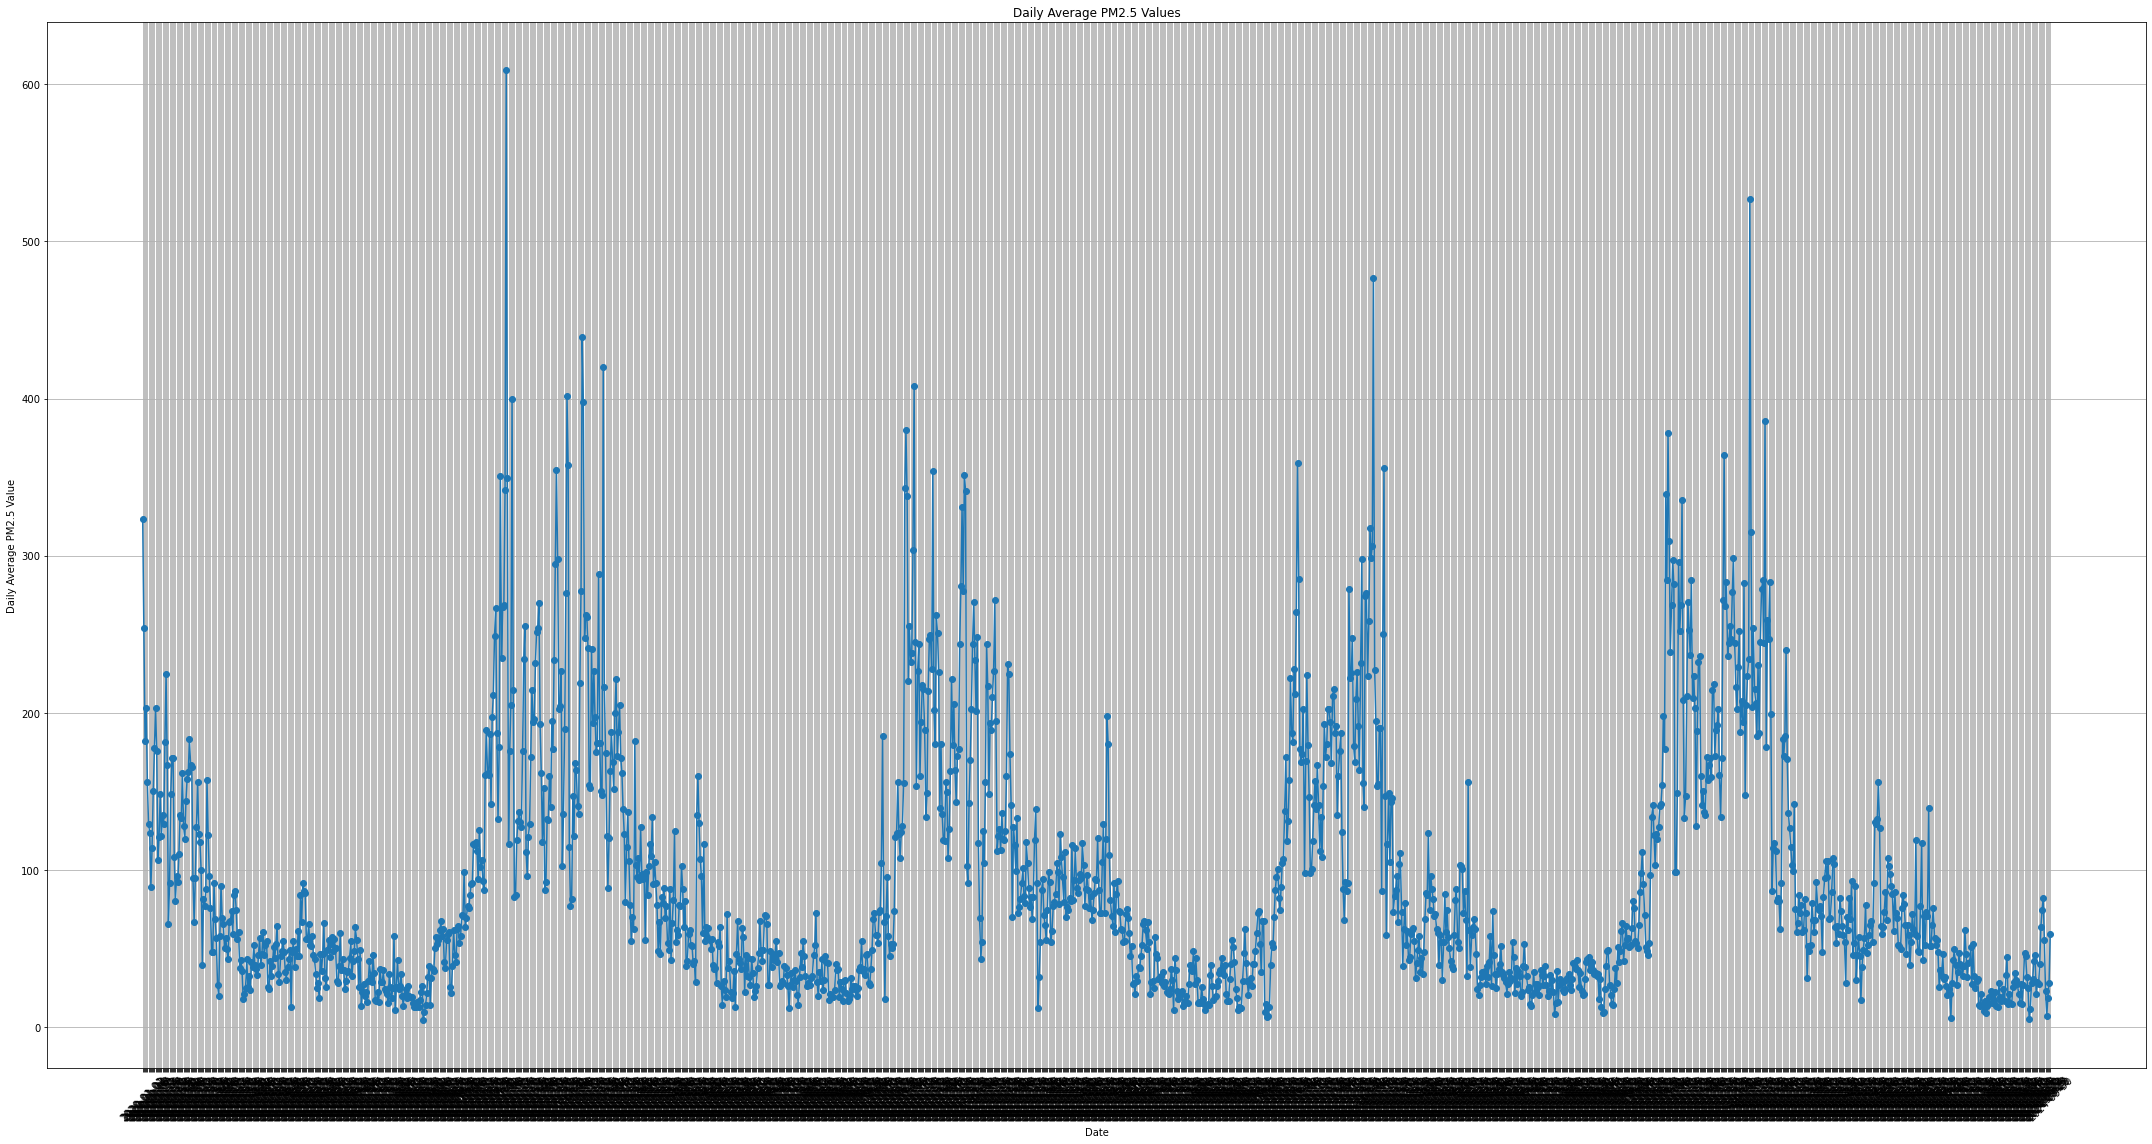

In [8]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(30, 16))
plt.plot(finaldata['Date'].to_numpy(),  finaldata['Daily_Average_Value'].to_numpy(), marker='o')  # Use 'Date' as x-axis
plt.title('Daily Average PM2.5 Values')
plt.xlabel('Date')
plt.ylabel('Daily Average PM2.5 Value')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [53]:

finaldata['Date'] = pd.to_datetime(finaldata['Date'])  # Ensure Date is in datetime format

finaldata['Month'] = finaldata['Date'].dt.to_period('M')


monthly_avg = finaldata.groupby('Month')['Daily_Average_Value'].mean().reset_index()

monthly_avg['Month'] = monthly_avg['Month'].dt.to_timestamp()
# Set 'Month' as the index
monthly_avg = monthly_avg.set_index('Month')

# Now monthly_avg will have 'Month' as its index and can be plotted directly

In [54]:
monthly_avg.head()

,Daily_Average_Value
Month,
2020-01-01,149.677186
2020-02-01,118.369383
2020-03-01,53.976897
2020-04-01,42.850810
2020-05-01,49.902506


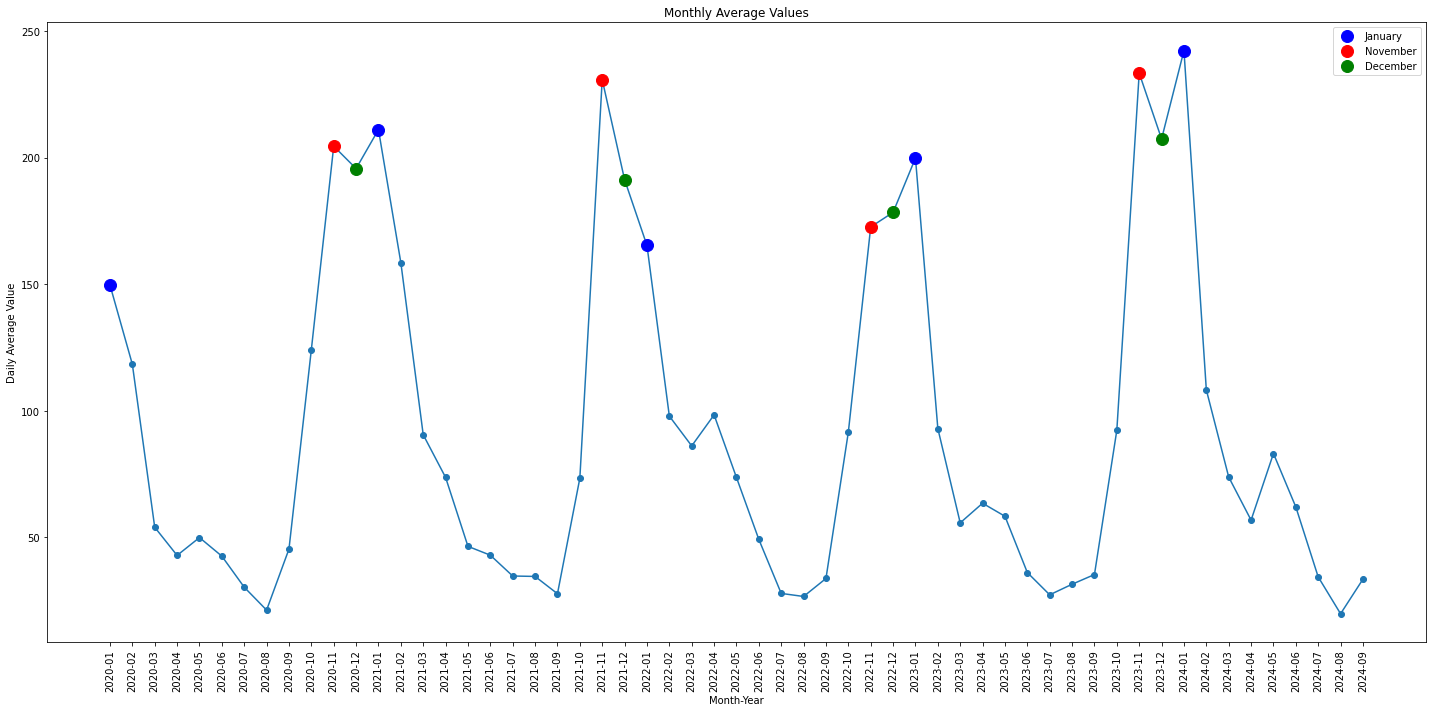

In [86]:
plt.figure(figsize=(20, 10))

# Main plot
plt.plot(monthly_avg.index.to_numpy(), monthly_avg['Daily_Average_Value'].to_numpy(), marker='o')

# Highlight November and December points
jan_mask = monthly_avg.index.str.contains('-01')
nov_mask = monthly_avg.index.str.contains('-11')
dec_mask = monthly_avg.index.str.contains('-12')

plt.plot(monthly_avg[jan_mask].index.to_numpy(), monthly_avg[jan_mask]['Daily_Average_Value'].to_numpy(), 
         'bo', markersize=12, label='January')
plt.plot(monthly_avg[nov_mask].index.to_numpy(), monthly_avg[nov_mask]['Daily_Average_Value'].to_numpy(), 
         'ro', markersize=12, label='November')
plt.plot(monthly_avg[dec_mask].index.to_numpy(), monthly_avg[dec_mask]['Daily_Average_Value'].to_numpy(), 
         'go', markersize=12, label='December')

plt.title('Monthly Average Values')
plt.xlabel('Month-Year')
plt.ylabel('Daily Average Value')
plt.grid(False)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randrange
from pandas import Series
from matplotlib import pyplot
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


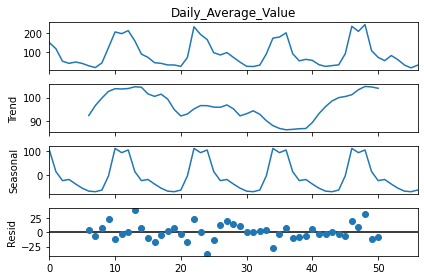

In [13]:
result = seasonal_decompose(monthly_avg['Daily_Average_Value'], model='additive', period=12)
result.plot()
pyplot.show()

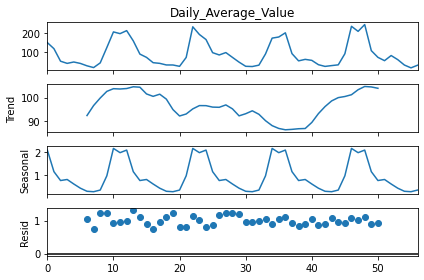

In [14]:
result = seasonal_decompose(monthly_avg['Daily_Average_Value'], model='multiplicative', period=12)
result.plot()
pyplot.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value}')
    
    if result[1] < 0.05:
        print("Reject the null hypothesis: The series is stationary.")
    else:
        print("Fail to reject the null hypothesis: The series is non-stationary.")

# Example usage
check_stationarity(monthly_avg['Daily_Average_Value'])


ADF Statistic: -1.2811433618739372
p-value: 0.6377544918081612
Critical Values:
    1%: -3.584828853223594
    5%: -2.9282991495198907
    10%: -2.6023438271604937
Fail to reject the null hypothesis: The series is non-stationary.


In [16]:
differenced_series = monthly_avg['Daily_Average_Value'].diff().dropna()
check_stationarity(differenced_series)


ADF Statistic: -4.2277179758248735
p-value: 0.0005912200924020106
Critical Values:
    1%: -3.5885733964124715
    5%: -2.929885661157025
    10%: -2.6031845661157025
Reject the null hypothesis: The series is stationary.


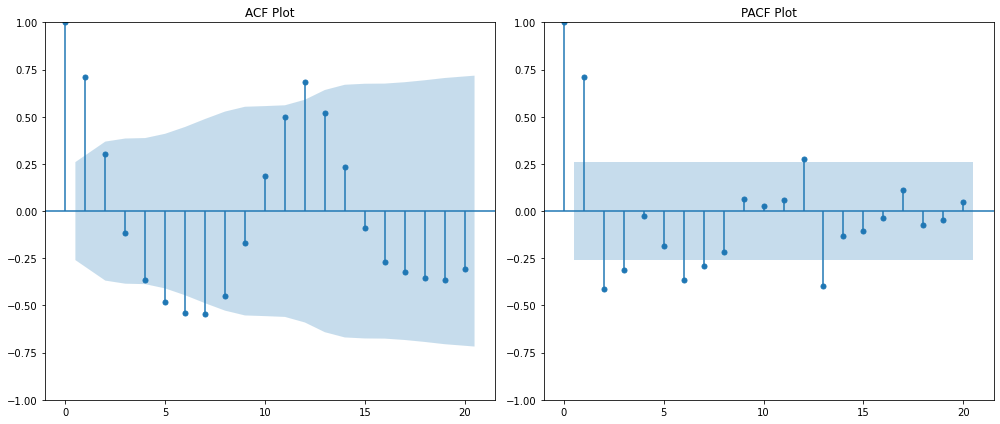

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Plot ACF
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(monthly_avg['Daily_Average_Value'], lags=20, ax=plt.gca())
plt.title('ACF Plot')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(monthly_avg['Daily_Average_Value'], lags=20, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()


In [23]:
from statsmodels.tsa.arima.model import ARIMA
acf_list = [1,5,6,7,12]
pacf_list = [1,2,3,6,7,12,13]

fitted_model_dict = {}

for p in pacf_list:
    for q in acf_list:
        arma_model = ARIMA(monthly_avg['Daily_Average_Value'], order=(p, 0, q))
        arma_model_fit = arma_model.fit()
            
        aic_score = arma_model_fit.aic
        bic_score = arma_model_fit.bic
    
        fitted_model_dict[(p, q)] = {'AIC': aic_score, 'BIC': bic_score}
       


/home/shubham/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/shubham/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/shubham/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/shubham/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/shubham/.local/lib/python3.10/site-packages/stat

In [24]:
for (p, q), scores in fitted_model_dict.items():
    print(f'ARMA({p},{q}) - AIC: {scores["AIC"]}, BIC: {scores["BIC"]}')

ARMA(1,1) - AIC: 599.8097087153996, BIC: 607.9819137867378
ARMA(1,5) - AIC: 586.6430901481493, BIC: 602.9875002908258
ARMA(1,6) - AIC: 586.1110554998002, BIC: 604.4985169103111
ARMA(1,7) - AIC: 585.1772700812548, BIC: 605.6077827596004
ARMA(1,12) - AIC: 576.4926950030202, BIC: 607.1384640205384
ARMA(2,1) - AIC: 575.202990267712, BIC: 585.4182466068847
ARMA(2,5) - AIC: 588.5195517238436, BIC: 606.9070131343545
ARMA(2,6) - AIC: 569.0995964070254, BIC: 589.5301090853709
ARMA(2,7) - AIC: 572.849634294098, BIC: 595.3231982402781
ARMA(2,12) - AIC: 575.1674905719226, BIC: 607.8563108572754
ARMA(3,1) - AIC: 576.8922680115867, BIC: 589.150575618594
ARMA(3,5) - AIC: 579.6277118802603, BIC: 600.0582245586058
ARMA(3,6) - AIC: 581.3006301141932, BIC: 603.7741940603732
ARMA(3,7) - AIC: 575.107681297779, BIC: 599.6242965117935
ARMA(3,12) - AIC: 571.5922728417435, BIC: 606.3241443949308
ARMA(6,1) - AIC: 569.9115791665598, BIC: 588.2990405770707
ARMA(6,5) - AIC: 581.0520366023218, BIC: 607.611703084170

In [28]:
split_index = int(len(series) * 0.8)

# Split the data
train_data = series[:split_index]
test_data = series[split_index:]

# Check the results
print("Training Data:\n", train_data)
print("Testing Data:\n", test_data)

Training Data:
 0     149.677186
1     118.369383
2      53.976897
3      42.850810
4      49.902506
5      42.563649
6      30.292512
7      21.238542
8      45.354809
9     124.153385
10    204.544027
11    195.691401
12    211.095138
13    158.516311
14     90.524541
15     73.670092
16     46.432884
17     42.934373
18     34.712588
19     34.545052
20     27.710609
21     73.336206
22    230.847008
23    191.311791
24    165.323749
25     97.889287
26     86.118124
27     98.380709
28     73.649359
29     49.172900
30     27.835766
31     26.626610
32     33.730949
33     91.543420
34    172.633816
35    178.389775
36    199.843908
37     92.992391
38     55.715208
39     63.470000
40     58.313932
41     36.084886
42     27.282082
43     31.459830
44     35.295898
Name: Daily_Average_Value, dtype: float64
Testing Data:
 45     92.309003
46    233.408396
47    207.410359
48    242.324302
49    108.252374
50     73.818878
51     56.780842
52     83.106266
53     61.995335
54     34

/home/shubham/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


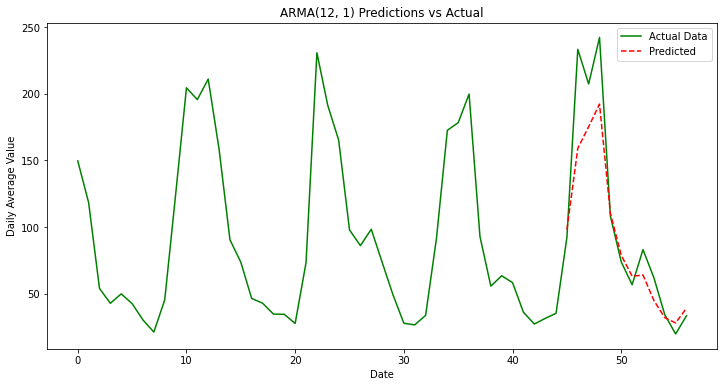

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming monthly_avg['Daily_Average_Value'] is your time series
# series = monthly_avg['Daily_Average_Value']


# Fit the ARMA model
model = ARIMA(train_data, order=(12, 0, 1))  # ARMA(12, 1) is equivalent to ARIMA with d=0
fitted_model = model.fit()

# Generate predictions
predictions = fitted_model.forecast(steps=len(test_data))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(series.index.to_numpy(), series.to_numpy(), label='Actual Data', color='green')
# plt.plot(test_data.index.to_numpy(), test_data.to_numpy(), label='Actual', color='blue')
plt.plot(test_data.index.to_numpy(), predictions.to_numpy(), label='Predicted', color='red', linestyle='--')
plt.title('ARMA(12, 1) Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Daily Average Value')
plt.legend()
plt.show()


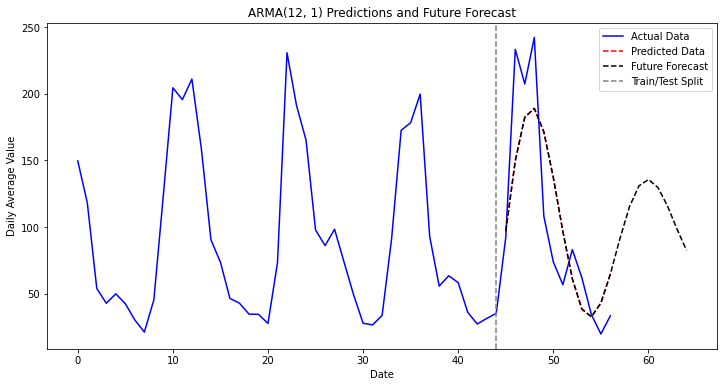

Future Forecast Values:
45     96.826101
46    149.902135
47    182.466343
48    189.103162
49    171.521834
50    137.211294
51     96.836953
52     61.187140
53     38.484063
54     32.678439
55     43.023096
56     64.865785
57     91.307041
58    115.200410
59    130.955152
60    135.720282
61    129.736604
62    115.877120
63     98.594676
64     82.614286
Name: predicted_mean, dtype: float64


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming monthly_avg['Daily_Average_Value'] is your time series
# series = monthly_avg['Daily_Average_Value']

# Split your data into train and test
split_index = int(len(series) * 0.8)
train_data = series[:split_index]
test_data = series[split_index:]

# Fit the ARMA model
model = ARIMA(train_data, order=(2, 0, 1))  # ARMA(12, 1) is equivalent to ARIMA with d=0
fitted_model = model.fit()

# Generate predictions for the length of the test dataset
predictions = fitted_model.forecast(steps=len(test_data))

# Forecast the next 9 data points
future_forecast = fitted_model.forecast(steps=20)



# Create a DataFrame for future predictions
future_series = pd.Series(future_forecast)

# Plot the entire data with predictions and future forecast
plt.figure(figsize=(12, 6))
plt.plot(series.index.to_numpy(), series.to_numpy(), label='Actual Data', color='blue')
plt.plot(predictions.index.to_numpy(), predictions.to_numpy(), label='Predicted Data', color='red', linestyle='--')
plt.plot(future_series.index.to_numpy(), future_series.to_numpy(), label='Future Forecast', color='black', linestyle='--')
plt.axvline(x=train_data.index[-1], color='gray', linestyle='--', label='Train/Test Split')
plt.title('ARMA(12, 1) Predictions and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Daily Average Value')
plt.legend()
plt.show()

# Print the future forecast values
print("Future Forecast Values:")
print(future_series)


/home/shubham/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99295D+00    |proj g|=  9.74171D-02

At iterate    5    f=  4.95379D+00    |proj g|=  2.69098D-02

At iterate   10    f=  4.91676D+00    |proj g|=  9.74755D-02

At iterate   15    f=  4.76859D+00    |proj g|=  6.30373D-02

At iterate   20    f=  4.74130D+00    |proj g|=  4.39332D-03

At iterate   25    f=  4.74018D+00    |proj g|=  4.08441D-03

At iterate   30    f=  4.73949D+00    |proj g|=  4.20624D-04

At iterate   35    f=  4.73946D+00    |proj g|=  2.50219D-04

At iterate   40    f=  4.73943D+00    |proj g|=  1.07540D-03

At iterate   45    f=  4.73886D+00    |proj g|=  9.89798D-03


/home/shubham/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.73495D+00    |proj g|=  3.24845D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   3.248D-02   4.735D+00
  F =   4.7349546581255755     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


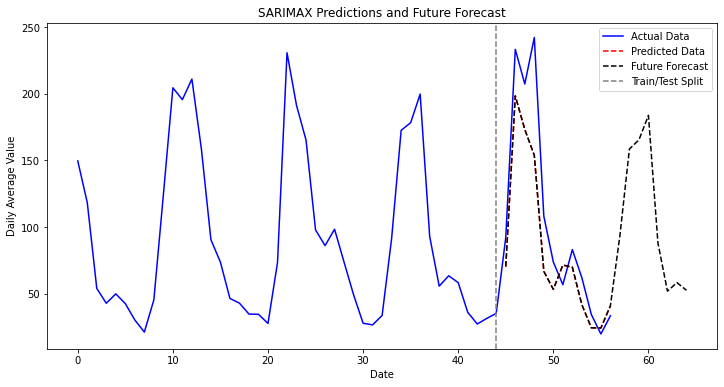

Future Forecast Values:
45     70.312321
46    198.470271
47    173.264287
48    153.885711
49     66.816685
50     53.297111
51     71.524692
52     69.893688
53     41.727783
54     24.413494
55     24.279342
56     40.945541
57     93.672706
58    158.629139
59    165.455219
60    183.840929
61     87.937887
62     51.929996
63     58.331223
64     52.583217
Name: predicted_mean, dtype: float64


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming monthly_avg['Daily_Average_Value'] is your time series
# series = monthly_avg['Daily_Average_Value']

# Split your data into train and test
split_index = int(len(series) * 0.8)
train_data = series[:split_index]
test_data = series[split_index:]

# Fit the SARIMAX model
# Specify (p, d, q) and seasonal_order (P, D, Q, s)
model = SARIMAX(train_data, order=(2, 0, 1), seasonal_order=(2, 0, 1, 12))  # Adjust seasonal parameters as needed
fitted_model = model.fit()

# Generate predictions for the length of the test dataset
predictions = fitted_model.forecast(steps=len(test_data))

# Forecast the next 20 data points
future_forecast = fitted_model.forecast(steps=20)

# Create a DataFrame for future predictions
future_series = pd.Series(future_forecast)

# Plot the entire data with predictions and future forecast
plt.figure(figsize=(12, 6))
plt.plot(series.index.to_numpy(), series.to_numpy(), label='Actual Data', color='blue')
plt.plot(predictions.index.to_numpy(), predictions.to_numpy(), label='Predicted Data', color='red', linestyle='--')
plt.plot(future_series.index.to_numpy(), future_series.to_numpy(), label='Future Forecast', color='black', linestyle='--')
plt.axvline(x=train_data.index[-1], color='gray', linestyle='--', label='Train/Test Split')
plt.title('SARIMAX Predictions and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Daily Average Value')
plt.legend()
plt.show()

# Print the future forecast values
print("Future Forecast Values:")
print(future_series)
